In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
#Constants
FOLDER_PATH = '/Users/AnshulSrivastava/Desktop/IPF/PI Data/CSVs'
SEED = 42

In [36]:
# Helper Functions

# Make baseline predictions
# Use previous time step to generate baseline predictions
def baseline_model(test):
    predictions = []
    for t in range(1, len(test)):
        yhat = test[t-1]
        predictions.append(yhat)
    
    return predictions

#Iterate through the test set for dynamic forecasting every 10 steps
def forecast(df, train_size, time_step):
    predictions = []
    train, test = df['Watt Hours Received'][:train_size].values.tolist(), df['Watt Hours Received'][train_size:].values.tolist()

    for t in tqdm(range(0, len(test), time_step)):
        model = ARIMA(train, order=(1, 1, 2), enforce_stationarity=False, enforce_invertibility=False) 
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=time_step)
        predictions.extend(yhat)
        obs = test[t:t+time_step]
        train.extend(obs)
    return predictions

# Plot test predictions vs actual
def plot_predictions(test, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions, color='red', label='Predicted', linestyle='dashed')
    plt.title('Test Set Predictions')
    plt.ylabel('Energy Consumption (KWatt Hours)')
    # turn off x-axis labels
    plt.xticks([])
    plt.legend()
    plt.show()

# Plot difference between true and predicted values
def plot_difference(df, test, predictions, train_size):
    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    plt.plot(df['Timestamp'].loc[train_size+1:], np.abs(np.array(test) - np.array(predictions[0:1404]))/np.array(test)*100, label='Percentage Error')
    plt.axhline(np.median(np.abs(np.array(test) - np.array(predictions[0:1404]))/np.array(test)*100), color='red', linestyle='dashed', label='Median Percentage Error')
    plt.title('Percentage Error between True and Predicted')
    plt.grid(alpha=0.3)
    plt.legend()

    plt.subplot(122)
    sns.histplot(np.abs(np.array(test) - np.array(predictions[0:1404]))/np.array(test)*100, label='Percentage Error', kde=True, bins=25)
    plt.title('Percentage Error Distribution')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


## FRIB

In [6]:
# Load data
frib = pd.read_csv(FOLDER_PATH + '/FRIB.csv')

In [7]:
# Check for missing values
na_mask = frib['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in FRIB data')

# Remove cumulative values
frib['Watt Hours Received'] = frib['Watt Hours Received'].diff()

# Drop the first row
frib = frib.dropna()

Found 0 missing values in FRIB data


In [8]:
# Convert to datetime
frib['Timestamp'] = pd.to_datetime(frib['Timestamp'])
frib.dtypes

Timestamp              datetime64[ns]
Watt Hours Received           float64
dtype: object

In [9]:
# Train test split
train_size = int(len(frib) * 0.8)
train, test = frib['Watt Hours Received'][:train_size].values.tolist(), frib['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(frib, train_size, 10)

  0%|          | 0/351 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

ValueError: Found input variables with inconsistent numbers of samples: [3507, 3510]

In [10]:
len(test), len(predictions)

(3508, 3510)

In [17]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.065
Test MAPE: 1.864%


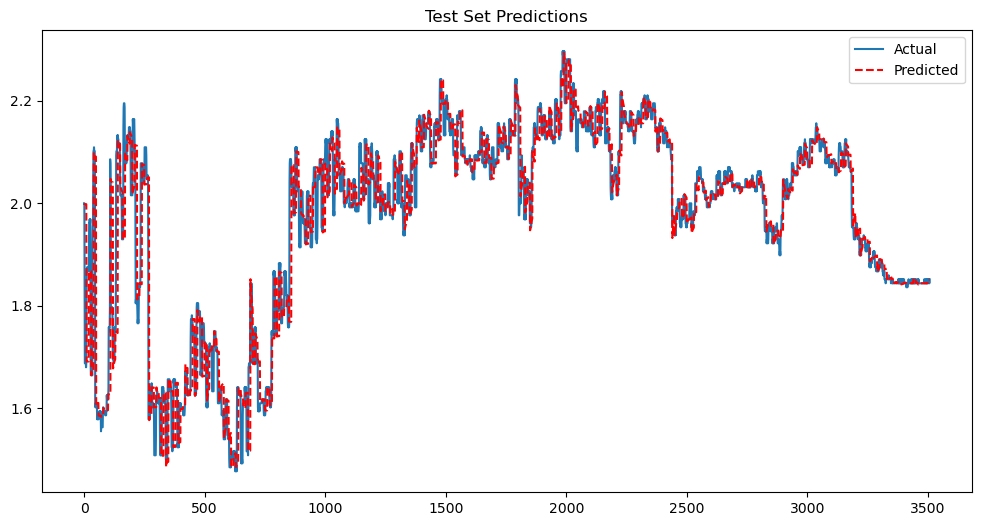

In [18]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

#### Sum consumption and compare with trefoil

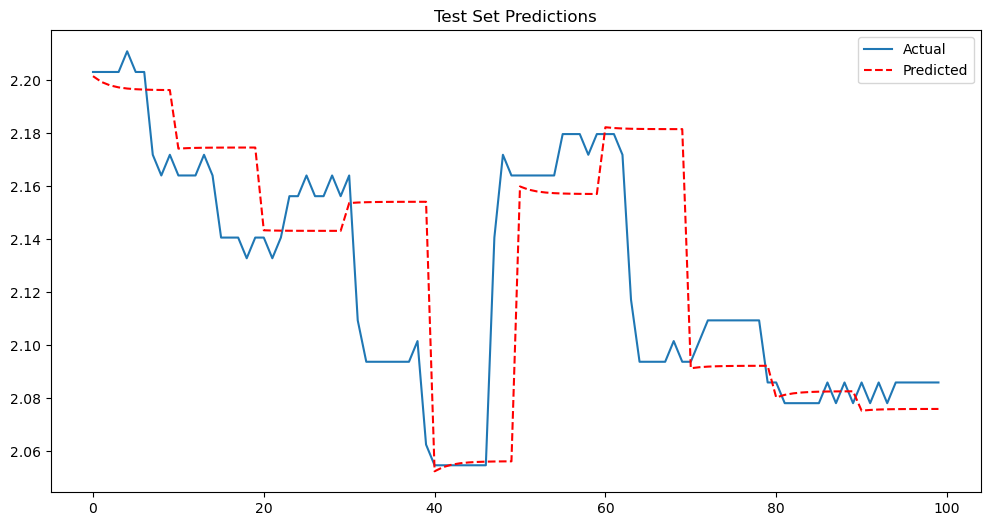

In [21]:
# Zoom in on the some 100 predictions
plot_predictions(test[1500:1600], predictions[1500:1600])

## BCC

In [22]:
bcc = pd.read_csv(FOLDER_PATH + '/BCC.csv')

In [23]:
#Check for NaN values
bcc['Watt Hours Received'] = pd.to_numeric(bcc['Watt Hours Received'], errors='coerce')
na_mask = bcc['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} NaN values in BCC data')
print(f'Lenght of BCC data before dropping NaN values: {len(bcc)}')

Found 18 NaN values in BCC data
Lenght of BCC data before dropping NaN values: 17543


In [24]:
#Drop NaN values
bcc = bcc.dropna(subset=['Watt Hours Received'])

In [25]:
# Remove cumulative values
bcc['Watt Hours Received'] = bcc['Watt Hours Received'].diff()

# Drop the first row
bcc = bcc.dropna()

# Convert to datetime
bcc['Timestamp'] = pd.to_datetime(bcc['Timestamp'])

In [26]:
# Train test split
train_size = int(len(bcc) * 0.8)
train, test = bcc['Watt Hours Received'][:train_size].values.tolist(), bcc['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(bcc, train_size, 10)

  0%|          | 0/351 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [27]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.038
Test MAPE: 20.906%


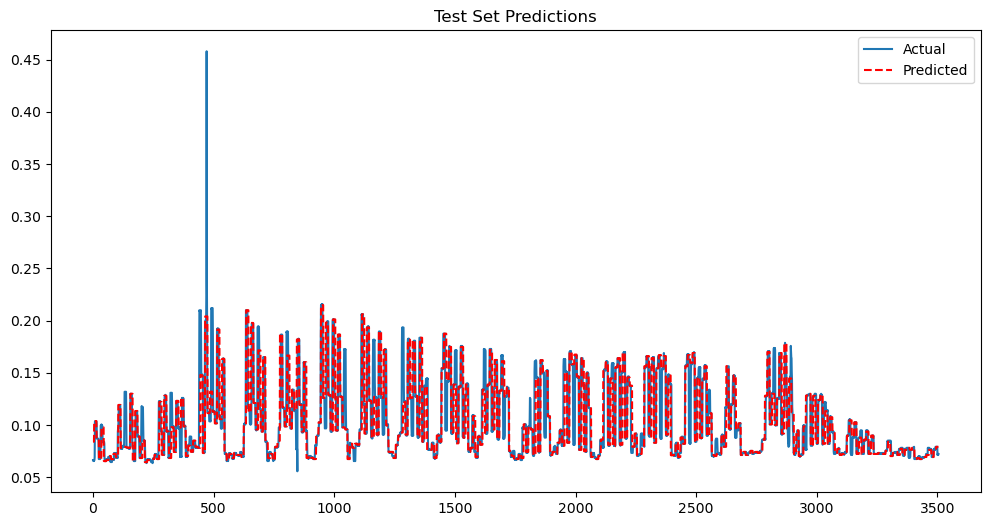

In [38]:
# Plot predictions
plot_predictions(test, predictions[5:len(test)+5])

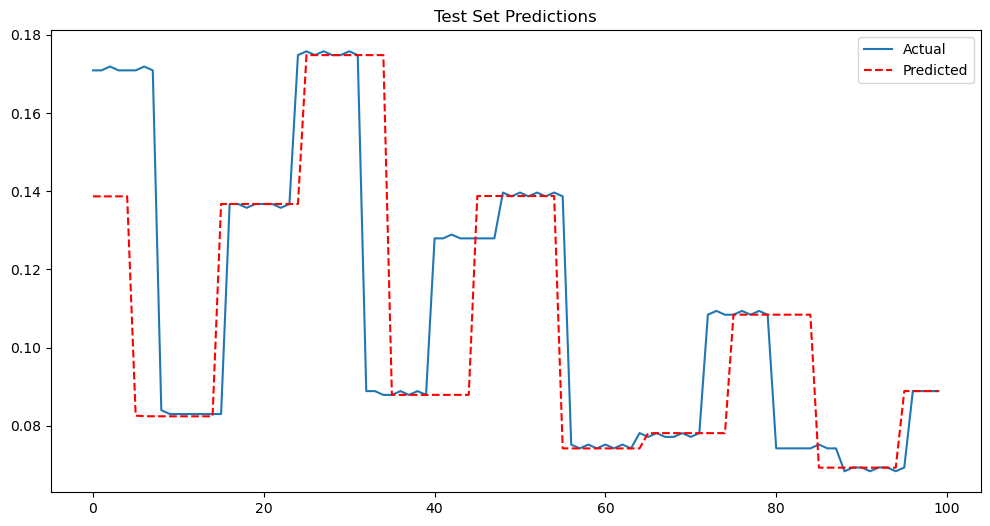

In [35]:
# Zoom in on some 100 predictions
plot_predictions(test[1500:1600], predictions[1500:1600])

## BPS Data

In [39]:
# Load data
bps = pd.read_csv(FOLDER_PATH + '/BPS.csv')

In [40]:
# Check for missing values
na_mask = bps['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in bps data')

# Remove cumulative values
bps['Watt Hours Received'] = bps['Watt Hours Received'].diff()

# Drop the first row
bps = bps.dropna()

Found 0 missing values in bps data


In [41]:
# Convert to datetime
bps['Timestamp'] = pd.to_datetime(bps['Timestamp'])

In [42]:
# Train test split
train_size = int(len(bps) * 0.8)
train, test = bps['Watt Hours Received'][:train_size].values.tolist(), bps['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(bps, train_size, 10)

  0%|          | 0/351 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [43]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.044
Test MAPE: 13.373%


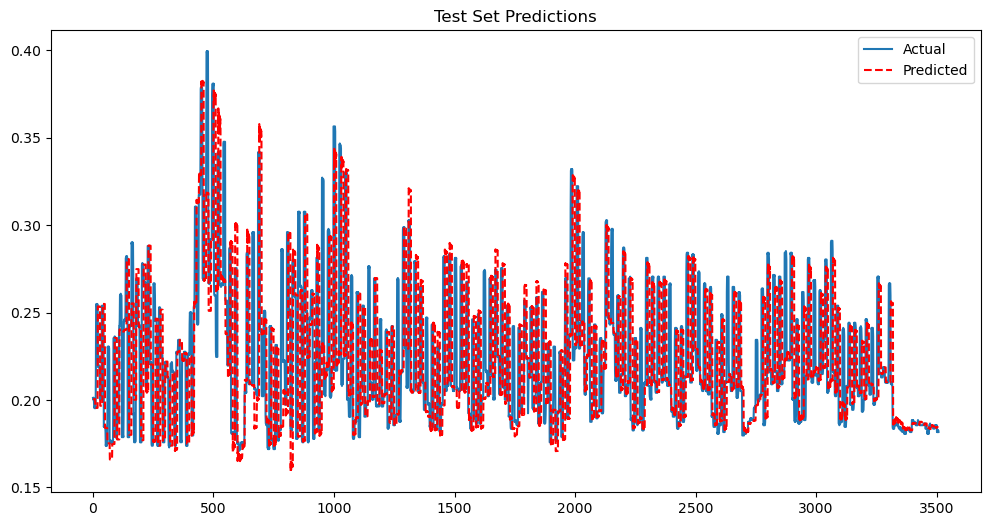

In [44]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

In [46]:
len(test), len(predictions)

(3509, 3510)

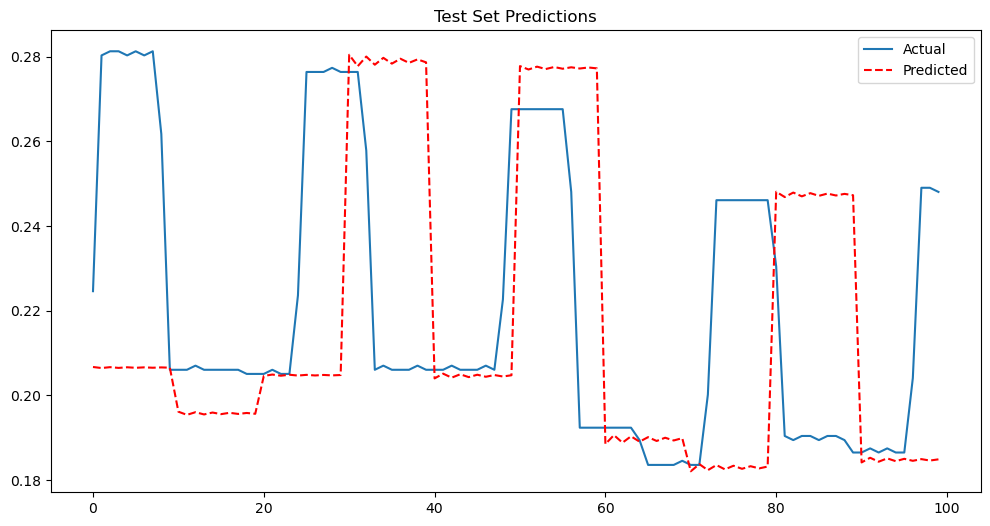

In [45]:
# Zoom in on the first 100 predictions
plot_predictions(test[1500:1600], predictions[1500:1600])

## Chem Data

In [4]:
# Load data
chem = pd.read_csv(FOLDER_PATH + '/Chem.csv')

In [5]:
# Calc Failed Mask
failed_mask = chem['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in Chem data')

chem[failed_mask]

Found 24 Calc Failed values in Chem data


,Timestamp,Watt Hours Received
1407,44985.666667,Calc Failed
1408,44985.708333,Calc Failed
1411,44985.833333,Calc Failed
1412,44985.875000,Calc Failed
1414,44985.958333,Calc Failed
1419,44986.166667,Calc Failed
1427,44986.500000,Calc Failed
1428,44986.541667,Calc Failed
1431,44986.666667,Calc Failed
1443,44987.166667,Calc Failed


Scattered throughout, can be dropped

In [6]:
# Convert to numeric
chem['Watt Hours Received'] = pd.to_numeric(chem['Watt Hours Received'], errors='coerce')

In [7]:
# Check for missing values
na_mask = chem['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in chem data')

# Drop NaN values
chem = chem.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
chem['Watt Hours Received'] = chem['Watt Hours Received'].diff()

# Drop the first row
chem = chem.dropna()

# Convert to datetime
chem['Timestamp'] = pd.to_datetime(chem['Timestamp'])

Found 24 missing values in chem data


In [8]:
# Train test split
train_size = int(len(chem) * 0.8)
train, test = chem['Watt Hours Received'][:train_size].values.tolist(), chem['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(chem, train_size, 10)

  0%|          | 0/351 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [9]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.009
Test MAPE: 4.141%


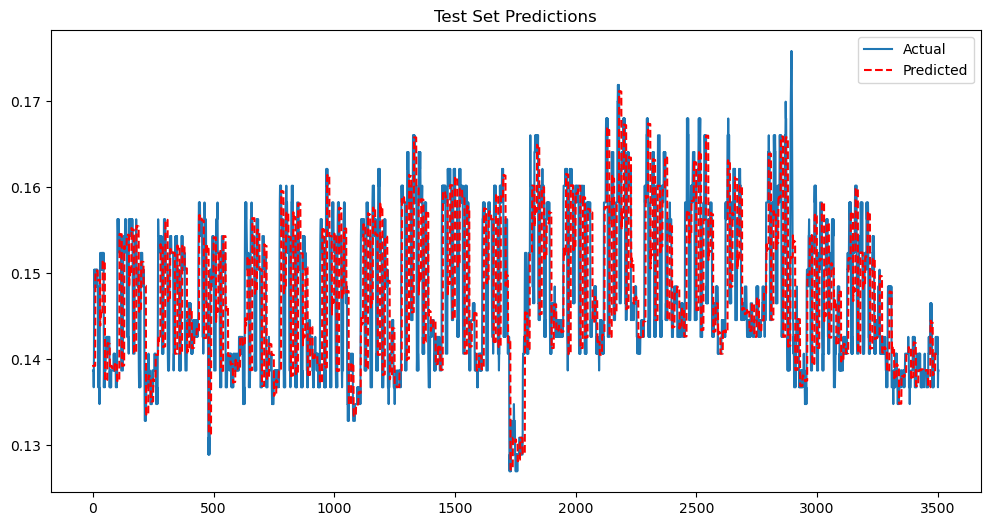

In [10]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

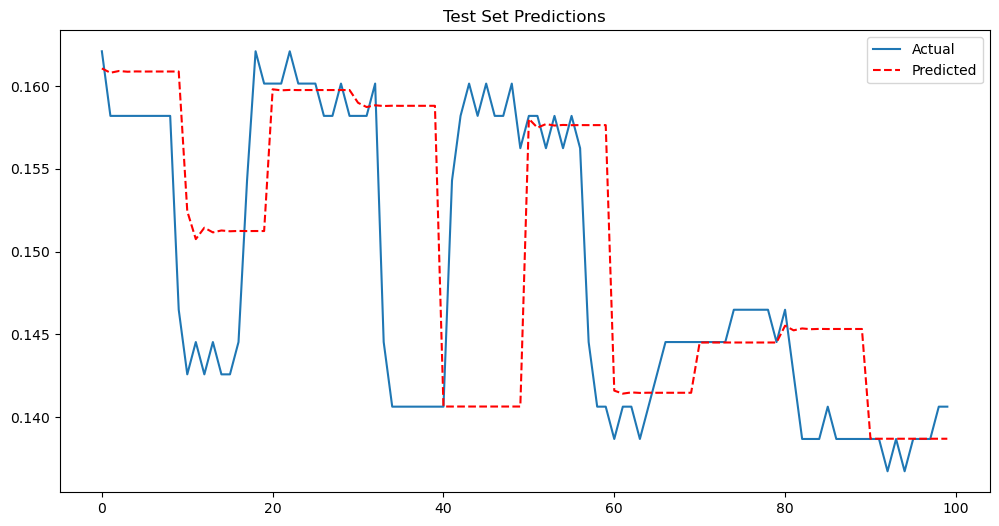

In [11]:
# Zoom in on the first 100 predictions
plot_predictions(test[1500:1600], predictions[1500:1600])

## Engineering Data

In [12]:
# Load Data
eng = pd.read_csv(FOLDER_PATH + '/Eng.csv')

In [13]:
# Calc Failed Mask
failed_mask = eng['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in eng data')

eng[failed_mask]

Found 1456 Calc Failed values in eng data


,Timestamp,Watt Hours Received
576,44951.041667,Calc Failed
8088,45264.041667,Calc Failed
11113,45390.125000,Calc Failed
11114,45390.166667,Calc Failed
11115,45390.208333,Calc Failed
...,...,...
12562,45450.500000,Calc Failed
12563,45450.541667,Calc Failed
12564,45450.583333,Calc Failed
12565,45450.625000,Calc Failed


In [14]:
# Split the data based on the failed mask
eng1 = eng.iloc[:11113]
eng2 = eng.iloc[12567:]

# Convert to numeric
eng1['Watt Hours Received'] = pd.to_numeric(eng1['Watt Hours Received'], errors='coerce')

eng2['Watt Hours Received'] = pd.to_numeric(eng2['Watt Hours Received'], errors='coerce')

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_528/1927974519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng1['Watt Hours Received'] = pd.to_numeric(eng1['Watt Hours Received'], errors='coerce')
/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_528/1927974519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng2['Watt Hours Received'] = pd.to_numeric(eng2['Watt Hours Received'], errors='coerce')


In [15]:
# # Check for missing values
na_mask = eng1['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in eng1 data')

# Drop NaN values
eng1 = eng1.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
eng1['Watt Hours Received'] = eng1['Watt Hours Received'].diff()

# Drop the first row
eng1 = eng1.dropna()

# Convert to datetime
eng1['Timestamp'] = pd.to_datetime(eng1['Timestamp'])

Found 2 missing values in eng1 data


In [16]:
# Check for missing values
na_mask = eng2['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in eng2 data')

# Drop NaN values
eng2 = eng2.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
eng2['Watt Hours Received'] = eng2['Watt Hours Received'].diff()

# Drop the first row
eng2 = eng2.dropna()

# Convert to datetime
eng2['Timestamp'] = pd.to_datetime(eng2['Timestamp'])

Found 0 missing values in eng2 data


In [17]:
# Train test split
train_size = int(len(eng1) * 0.8)
train, test = eng1['Watt Hours Received'][:train_size].values.tolist(), eng1['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(eng1, train_size, 10)

  0%|          | 0/223 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [18]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.007
Test MAPE: 10921703274979.484%


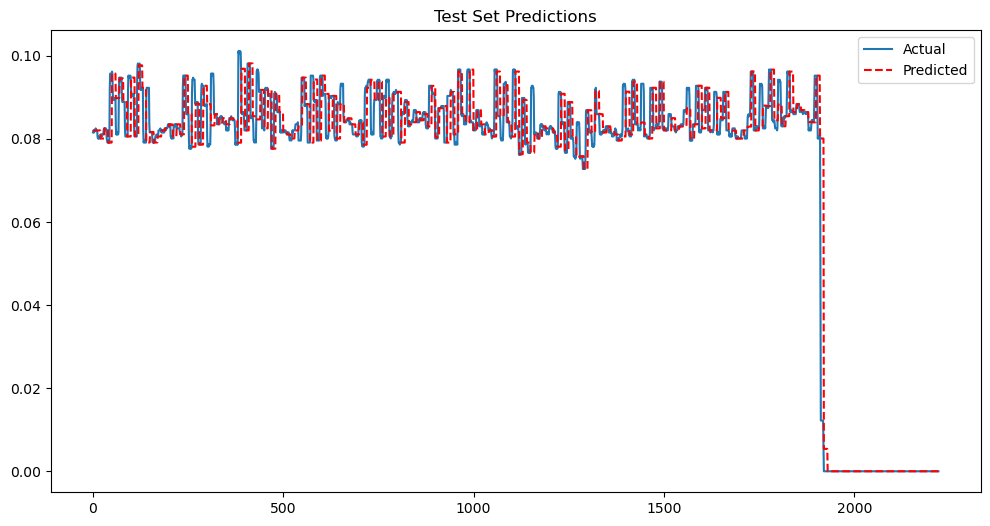

In [19]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

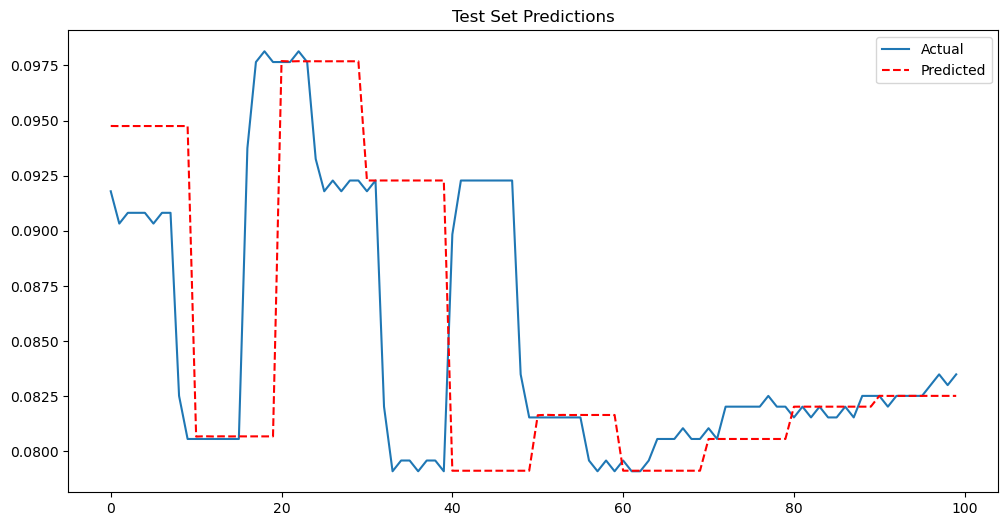

In [20]:
# Zoom in on the first 100 predictions
plot_predictions(test[100:200], predictions[100:200])

In [21]:
# Train test split
train_size = int(len(eng2) * 0.8)
train, test = eng2['Watt Hours Received'][:train_size].values.tolist(), eng2['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(eng2, train_size, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [22]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.005
Test MAPE: 3.564%


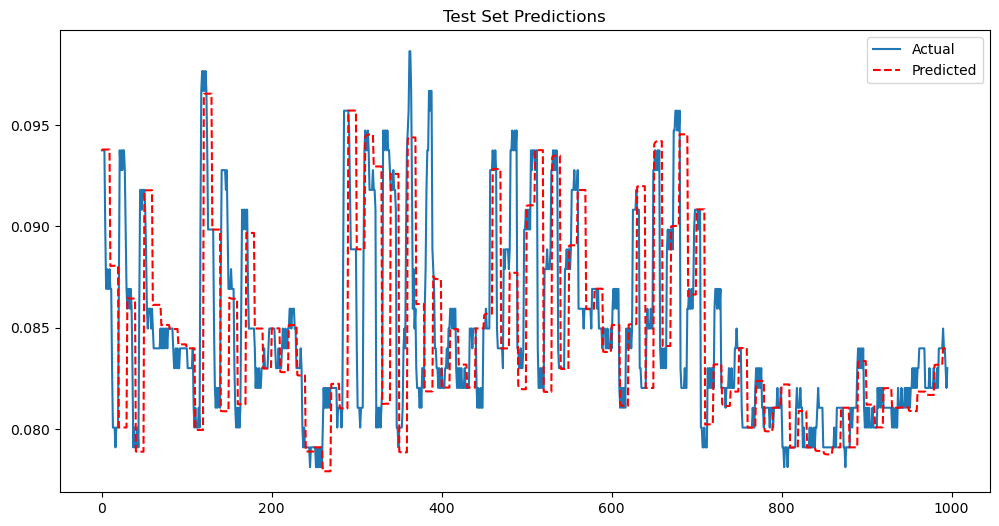

In [23]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

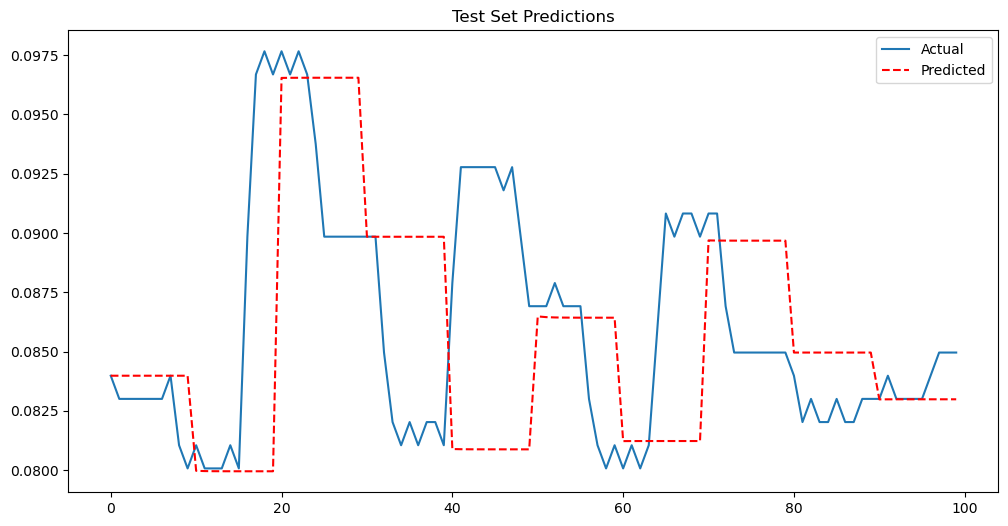

In [24]:
# Zoom in on the first 100 predictions
plot_predictions(test[100:200], predictions[100:200])

## Plant and Soil Sciences Data

In [25]:
pss = pd.read_csv(FOLDER_PATH + '/PSS.csv')

In [26]:
# Calc Failed Mask
failed_mask = pss['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in eng data')

pss[failed_mask]

Found 4 Calc Failed values in eng data


,Timestamp,Watt Hours Received
9346,45316.458333,Calc Failed
9347,45316.500000,Calc Failed
9348,45316.541667,Calc Failed
9349,45316.583333,Calc Failed


In [27]:
# Convert to numeric
pss['Watt Hours Received'] = pd.to_numeric(pss['Watt Hours Received'], errors='coerce')

In [28]:
# Check for missing values
na_mask = pss['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in pss data')

# Drop NaN values
pss = pss.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
pss['Watt Hours Received'] = pss['Watt Hours Received'].diff()

# Drop the first row
pss = pss.dropna()

# Convert to datetime
pss['Timestamp'] = pd.to_datetime(pss['Timestamp'])

Found 4 missing values in pss data


In [29]:
# Train test split
train_size = int(len(pss) * 0.8)
train, test = pss['Watt Hours Received'][:train_size].values.tolist(), pss['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = forecast(pss, train_size, 10)

  0%|          | 0/351 [00:00<?, ?it/s]

/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivastava/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AnshulSrivast

In [30]:
# Calculate RMSE
error = np.sqrt(mean_squared_error(test, predictions[:len(test)]))
percentage_error = mean_absolute_percentage_error(test, predictions[:len(test)])
print('Test RMSE: %.3f' % error)
print(f'Test MAPE: {(percentage_error*100):.3f}%' )

Test RMSE: 0.013
Test MAPE: 3.469%


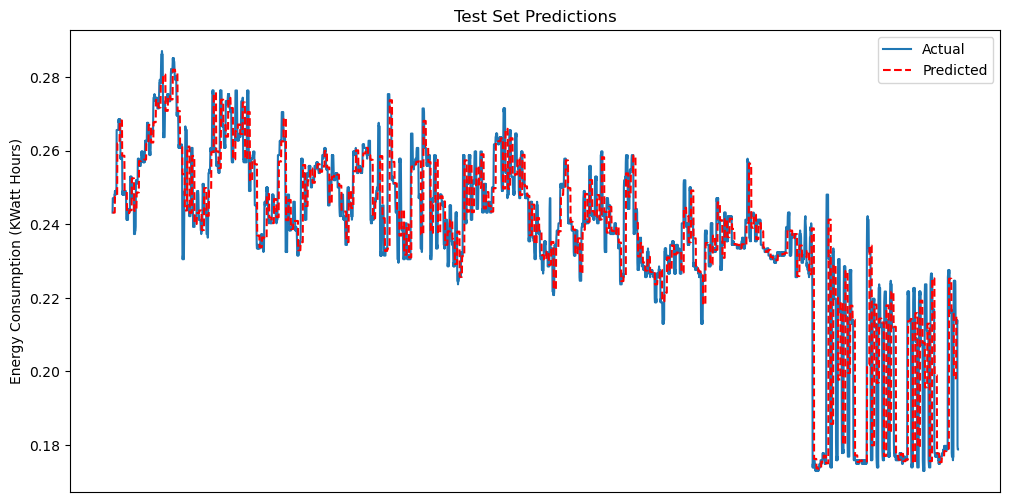

In [37]:
# Plot predictions
plot_predictions(test, predictions[:len(test)])

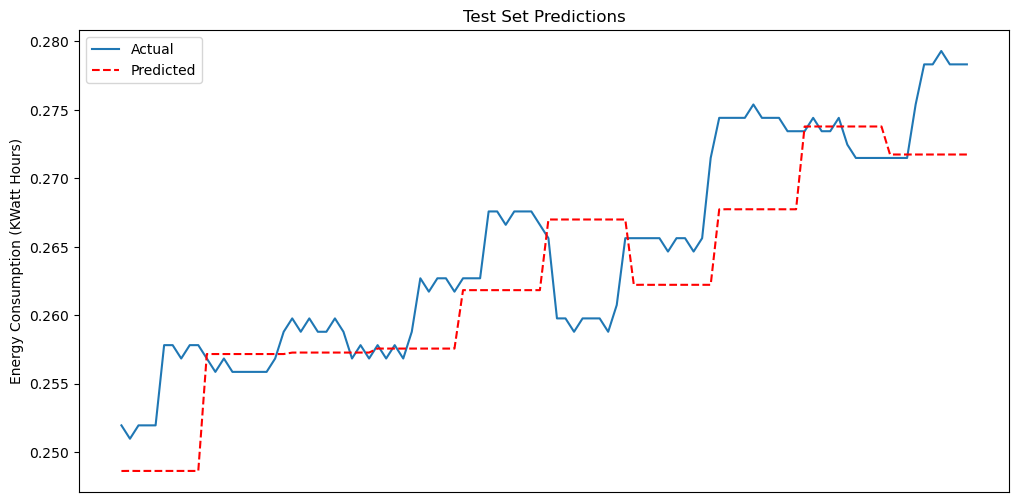

In [38]:
# Zoom in on the first 100 predictions
plot_predictions(test[100:200], predictions[100:200])

In [40]:
len(test), len(predictions)

(3508, 3510)

## Computer Center Data

In [ ]:
# Load data
cc = pd.read_csv(FOLDER_PATH + '/CC.csv')

In [ ]:
# Calc Failed Mask
failed_mask = cc['Watt Hours Received'] == 'Calc Failed'
print(f'Found {failed_mask.sum()} Calc Failed values in CC data')

cc[failed_mask]

Found 643 Calc Failed values in CC data


,Timestamp,Watt Hours Received
942,2023-02-09 08:00:00,Calc Failed
6132,2023-09-13 15:00:00,Calc Failed
6133,2023-09-13 16:00:00,Calc Failed
6134,2023-09-13 17:00:00,Calc Failed
6135,2023-09-13 18:00:00,Calc Failed
...,...,...
6818,2023-10-12 05:00:00,Calc Failed
6819,2023-10-12 06:00:00,Calc Failed
6820,2023-10-12 07:00:00,Calc Failed
6821,2023-10-12 08:00:00,Calc Failed


In [ ]:
cc1 = cc.iloc[:6131]
cc2 = cc.iloc[6823:]

# Convert to numeric
cc1['Watt Hours Received'] = pd.to_numeric(cc1['Watt Hours Received'], errors='coerce')

cc2['Watt Hours Received'] = pd.to_numeric(cc2['Watt Hours Received'], errors='coerce')

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_99000/607291112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc1['Watt Hours Received'] = pd.to_numeric(cc1['Watt Hours Received'], errors='coerce')
/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_99000/607291112.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc2['Watt Hours Received'] = pd.to_numeric(cc2['Watt Hours Received'], errors='coerce')


In [ ]:
# # Check for missing values
na_mask = cc1['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in cc1 data')

# Drop NaN values
cc1 = cc1.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
cc1['Watt Hours Received'] = cc1['Watt Hours Received'].diff()

# Drop the first row
cc1 = cc1.dropna()

# Convert to datetime
cc1['Timestamp'] = pd.to_datetime(cc1['Timestamp'])

Found 1 missing values in cc1 data


In [ ]:
# # Check for missing values
na_mask = cc2['Watt Hours Received'].isna()
print(f'Found {na_mask.sum()} missing values in cc2 data')

# Drop NaN values
cc2 = cc2.dropna(subset=['Watt Hours Received'])

# Remove cumulative values
cc2['Watt Hours Received'] = cc2['Watt Hours Received'].diff()

# Drop the first row
cc2 = cc2.dropna()

# Convert to datetime
cc2['Timestamp'] = pd.to_datetime(cc2['Timestamp'])

Found 0 missing values in cc2 data


In [ ]:
# Train test split
train_size = int(len(cc1) * 0.8)
train, test = cc1['Watt Hours Received'][:train_size].values.tolist(), cc1['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = baseline_model(test)

# Calculate RMSE
error = np.sqrt(mean_squared_error(test[1:], predictions))
percentage_error = mean_absolute_percentage_error(test[1:], predictions)
print('Test RMSE: %.3f' % error)
print('Test MAPE: %.3f' % percentage_error)

Test RMSE: 0.008
Test MAPE: 0.018


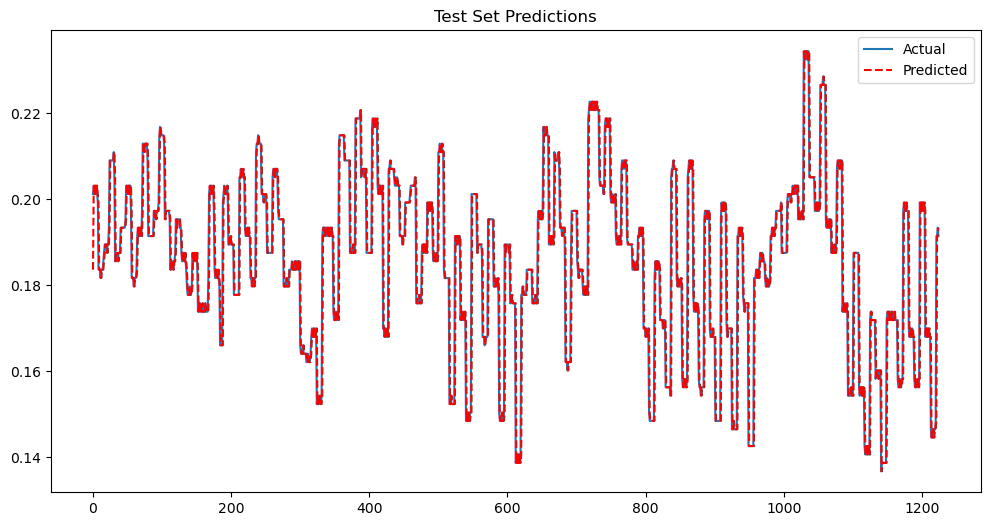

In [ ]:
# Plot predictions
plot_predictions(test[1:], predictions)

In [ ]:
# Train test split
train_size = int(len(cc2) * 0.8)
train, test = cc2['Watt Hours Received'][:train_size].values.tolist(), cc2['Watt Hours Received'][train_size:].values.tolist()

# Baseline model
predictions = baseline_model(test)

# Calculate RMSE
error = np.sqrt(mean_squared_error(test[1:], predictions))
percentage_error = mean_absolute_percentage_error(test[1:], predictions)
print('Test RMSE: %.3f' % error)
print('Test MAPE: %.3f' % percentage_error)

Test RMSE: 0.008
Test MAPE: 0.025


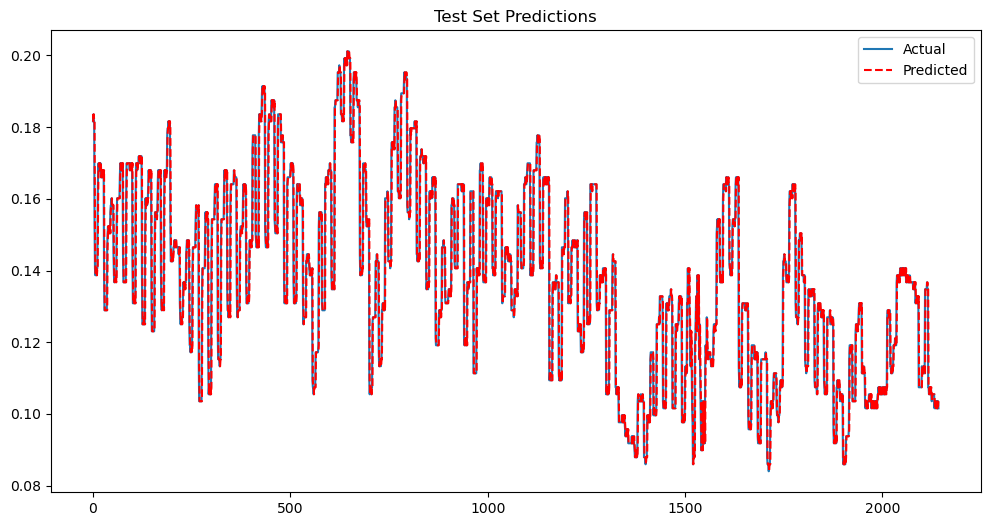

In [ ]:
# Plot predictions
plot_predictions(test[1:], predictions)